# Setup logistic diffusion model

In [2]:
%load_ext autoreload
%autoreload 2

In [14]:
%reload_ext autoreload
import torch
import time
import numpy as np
import doobhtransform as doob
from torch.distributions.gamma import Gamma
from doobhtransform.utils import normal_logpdf, negative_binomial_logpdf
from particlefilter.core import simulate_uncontrolled_SMC, simulate_controlled_SMC


In [4]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Computing on " + str(device))

Computing on cpu


In [5]:
# tuning parameters
d = 1 # dimension of latent state
theta = torch.tensor([2.397, 4.429e-03, 0.840, 1.0693], device=device)

# Latent process

In [6]:
# dict for objects relating to latent process
state = {}

# dimension of state
state["dim"] = d

# drift of diffusion
b_constant = theta[0] / theta[2]
b_factor = theta[1] / theta[2]
b = lambda theta, x: b_constant - b_factor * torch.exp(theta[2] * x)  # drift
state["drift"] = b

# diffusion coefficient of diffusion
sigma = torch.tensor(1.0, device=device)
state["sigma"] = sigma

# simulate initial states (from stationary distribution before Lamperti transformation)
alpha = 2.0 * (0.5 * theta[2] ** 2 + theta[0]) / theta[2] ** 2 - 1.0
beta = 2.0 * theta[1] / theta[2] ** 2
stationary_distribution = Gamma(alpha, beta)
rinit = lambda N: torch.log(stationary_distribution.sample((N, 1))) / theta[2]
state["rinit"] = rinit

# Observation model

In [7]:
# dict for objects relating to observations
obs = {}

# dimension of observation
p = d
obs["dim"] = p

# number of observations
T = 10
obs["num_obs"] = T

# observation time interval
interval = 1.0
obs["interval"] = interval

# log-observation density
obs_log_density = lambda theta, x, y: negative_binomial_logpdf(
    y, theta[3], torch.exp(theta[2] * x)
) # returns size (N)
obs["log_density"] = obs_log_density


# simulate observations
def simulate_obs(x):
    size = theta[3].numpy()
    prob = (theta[3] / (theta[3] + torch.exp(theta[2] * x))).numpy()
    out = torch.tensor(np.random.negative_binomial(n=size, p=prob))
    return out

num_step = 50
stepsize = torch.tensor(interval / num_step, device=device)
def observation(N):
    X = rinit(N) # (N, d)
    Y = torch.zeros(N, T, p, device=device)
    for t in range(T):
        for m in range(num_step):
            W = torch.sqrt(stepsize) * torch.randn(N, d, device=device)  # size (N, d)
            X = X + stepsize * b(theta, X) + sigma * W
        Y[:, t, :] = simulate_obs(X)
    return Y 

obs["robs"] = observation

# Simulate states and observations

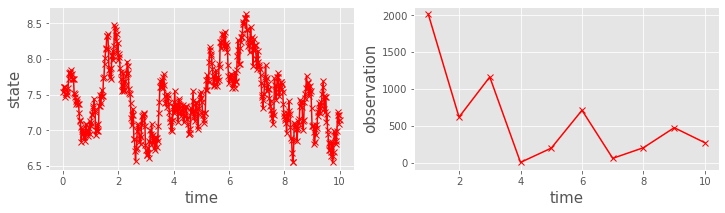

In [8]:
# simulate states and observations
X = torch.zeros(T * num_step + 1, d, device=device)
Y = torch.zeros(T, p, device=device)
X[0, :] = rinit(1) # (1, d)

for t in range(T):
    for m in range(num_step):
        W = torch.sqrt(stepsize) * torch.randn(1, d, device=device)  # size (1, d)
        index = t * num_step + m + 1
        X[index, :] = X[index - 1, :] + stepsize * b(theta, X[index - 1, :]) + sigma * W
    Y[t, :] = simulate_obs(X[index, :])

X0 = X[0, ]
obs["sequence"] = Y

# plot states and observations
times = torch.linspace(0.0, T * interval, T * num_step + 1, device=device)
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.plot(times, X[:, 0].cpu(), "r-x")
# plt.plot(torch.arange(1, T + 1), Y[:, 0].cpu(), "bx")
plt.xlabel("time", fontsize=15)
plt.ylabel("state", fontsize=15)

plt.subplot(1, 2, 2)
plt.plot(torch.arange(1, T + 1), Y[:, 0].cpu(), "r-x")
plt.xlabel("time", fontsize=15)
plt.ylabel("observation", fontsize=15)
plt.show()

# Train model

In [9]:
# learning standardization
N_large = 100000
X_N = rinit(N_large)
Y_N = observation(N_large).reshape((N_large * T, 1))

# means and standard deviations
standardization = {
    "x_mean": torch.mean(X, 0),
    "x_std": torch.std(X, 0),
    "y_mean": torch.mean(Y, 0),
    "y_std": torch.std(Y, 0),
}

standardization

{'x_mean': tensor([7.4606]),
 'x_std': tensor([0.4517]),
 'y_mean': tensor([571.7000]),
 'y_std': tensor([615.0845])}

In [10]:
# algorithm settings
M = 50
num_steps = M
V_net_config = {"layers": [16], "standardization": standardization}
Z_net_config = {"layers": [16], "standardization": standardization}
net_config = {"V": V_net_config, "Z": Z_net_config}
model = doob.core.model(state, obs, num_steps, net_config, device)

In [12]:
# optimization configuration
optim_config = {
    "minibatch": 100,
    "num_iterations": 1000,
    "learning_rate": 1e-2,
    "weight_decay": 1e-2,
    "initial_required": True,
}

# training
time_start = time.time()
model.train(theta, optim_config)
time_end = time.time()
time_elapsed = time_end - time_start
print("Training time (secs): " + str(time_elapsed))

  1%|          | 1/100 [00:00<00:20,  4.91it/s]

Optimization iteration: 1 Loss: 28.269126892089844


100%|██████████| 100/100 [00:20<00:00,  4.89it/s]

Optimization iteration: 100 Loss: 7.097320079803467
Training time (secs): 20.444098949432373


In [10]:
# more training
optim_config["initial_required"] = False
time_start = time.time()
model.train(theta, optim_config)
time_end = time.time()
time_elapsed = time_end - time_start
print("Training time (secs): " + str(time_elapsed))

  0%|          | 0/1000 [00:00<?, ?it/s]

Optimization iteration: 1 Loss: 10.09260082244873


 10%|█         | 102/1000 [00:07<01:11, 12.60it/s]

Optimization iteration: 100 Loss: 11.28891658782959


 20%|██        | 202/1000 [00:15<01:02, 12.75it/s]

Optimization iteration: 200 Loss: 11.817627906799316


 30%|███       | 302/1000 [00:22<00:50, 13.71it/s]

Optimization iteration: 300 Loss: 10.265093803405762


 40%|████      | 402/1000 [00:30<00:46, 12.94it/s]

Optimization iteration: 400 Loss: 11.357498168945312


 50%|█████     | 502/1000 [00:37<00:36, 13.65it/s]

Optimization iteration: 500 Loss: 9.722755432128906


 60%|██████    | 602/1000 [00:45<00:30, 13.23it/s]

Optimization iteration: 600 Loss: 9.897615432739258


 70%|███████   | 702/1000 [00:52<00:22, 13.16it/s]

Optimization iteration: 700 Loss: 10.62648868560791


 80%|████████  | 802/1000 [01:00<00:14, 13.36it/s]

Optimization iteration: 800 Loss: 11.557048797607422


 90%|█████████ | 902/1000 [01:07<00:07, 13.74it/s]

Optimization iteration: 900 Loss: 9.841341972351074


100%|██████████| 1000/1000 [01:15<00:00, 13.28it/s]

Optimization iteration: 1000 Loss: 11.05733871459961
Training time (secs): 75.29039907455444


# Run SMC

In [16]:
N = 2**10

In [17]:
_states, _ess, _log_norm_const, _log_ratio_norm_const = (
    simulate_uncontrolled_SMC(model, theta, X0, Y, N, resample=True, full_path=True)
)
print("Log-likelihood estimate: " + str(float(_log_ratio_norm_const)))

Log-likelihood estimate: -73.55693054199219


In [18]:
states, ess, log_norm_const, log_ratio_norm_const = (
    simulate_controlled_SMC(model, theta, X0, Y, N, resample=True, full_path=True)
)
print("Log-likelihood estimate: " + str(float(log_ratio_norm_const)))

Log-likelihood estimate: -73.53266143798828


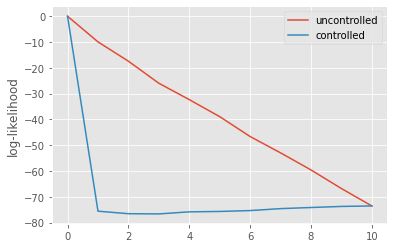

In [19]:
plt.figure()
plt.plot(_log_norm_const)
plt.plot(log_norm_const)
plt.ylabel("log-likelihood")
plt.legend(["uncontrolled", "controlled"])

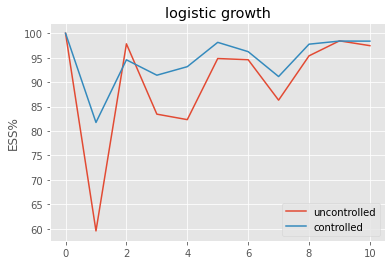

In [20]:
plt.figure()
plt.plot(_ess * 100 / N)
plt.plot(ess * 100 / N)
plt.title("logistic growth")
plt.ylabel("ESS%")
plt.legend(["uncontrolled", "controlled"])

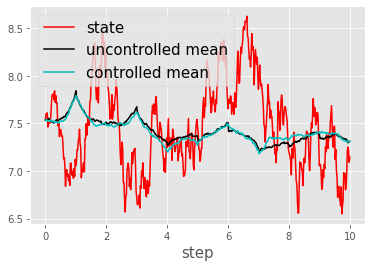

In [21]:
# plot states and observations (for full_path = False)
times = torch.linspace(0.0, T * interval, T * M + 1, device=device)
plt.figure()
plt.plot(times, X[:, 0], "r-")
plt.plot(times, torch.mean(states[:, :, 0], 0), "k-")
plt.plot(times, torch.mean(_states[:, :, 0], 0), 'c-')
# for n in range(N):
    # plt.plot(times, states[n, :, 0], 'k.', alpha = 0.01)
plt.xlabel("step", fontsize=15)
plt.legend(["state", "uncontrolled mean", "controlled mean"], fontsize=15)
plt.show()